# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import Common_Functions as f

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_percentage_error as mape

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

/Users/shrutikaushal/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = os.getcwd()+'/'

# Data Cleaning

1. Drop all rows with missing mcare_counts
2. Drop year column
3. Replace inf values with 0
4. Apply thresholding on the data

In [4]:
data = pd.read_csv(path+'Feature Matrix/processed_data.csv')
data.dropna(subset = ['mcare_count'], inplace = True)
data.drop(columns = ['year'], inplace = True)
data.replace([np.inf, -np.inf], 0, inplace=True)

In [5]:
model_data, future_data = f.data_split(data, count_thresh = 34)

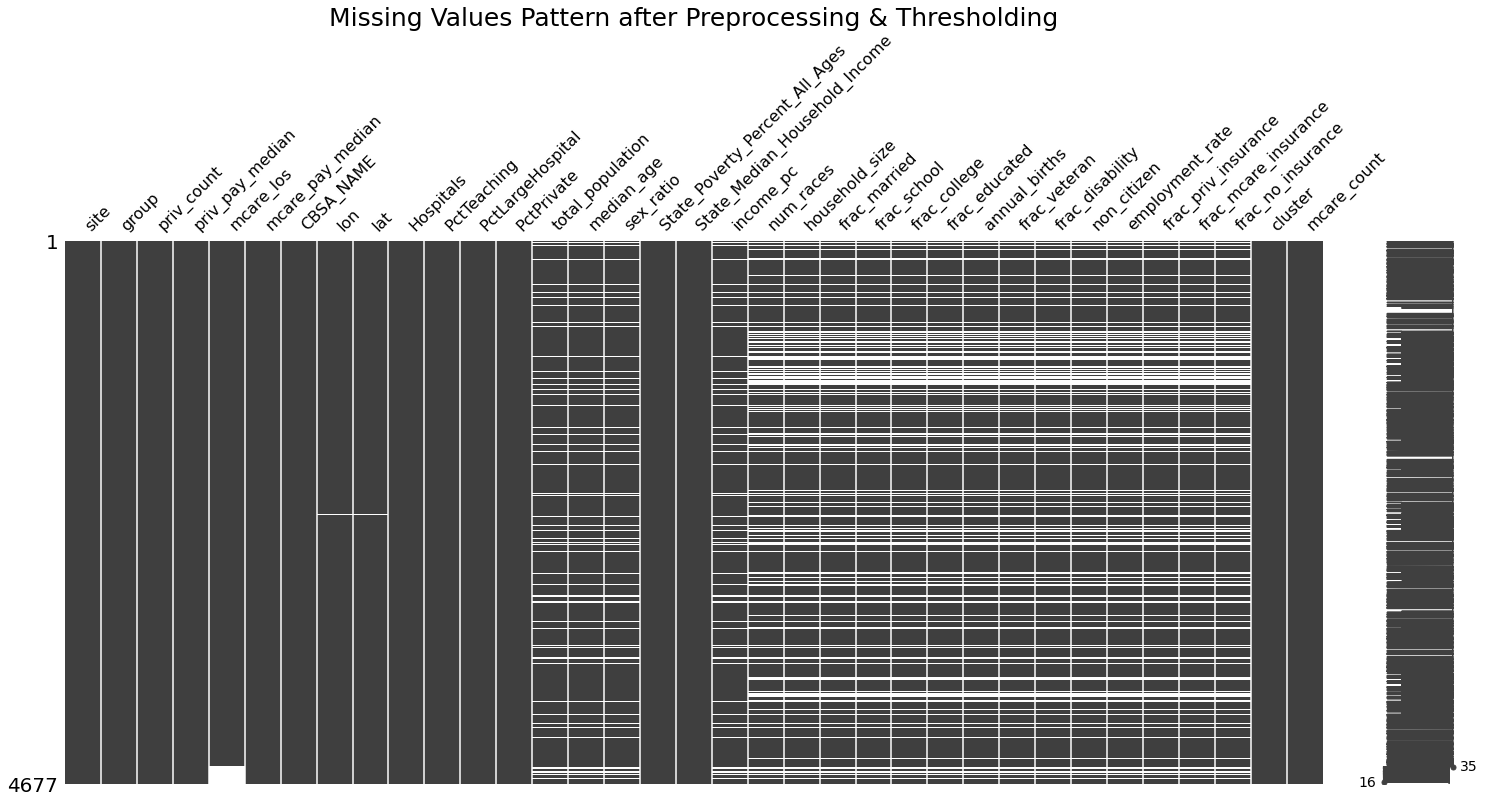

In [6]:
msno.matrix(model_data)
plt.title('Missing Values Pattern after Preprocessing & Thresholding', fontsize = 25)
plt.show()

# Spliting into Cluster Data

In [7]:
clusters = model_data.cluster.unique()
print(clusters)

[0 2 1]


In [8]:
data_0 = model_data[model_data.cluster == 0]
data_1 = model_data[model_data.cluster == 1]
data_2 = model_data[model_data.cluster == 2]

In [9]:
X0 = data_0.drop(columns = 'priv_pay_median')
y0 = data_0['priv_pay_median']

In [10]:
X1 = data_1.drop(columns = 'priv_pay_median')
y1 = data_1['priv_pay_median']

In [11]:
X2 = data_2.drop(columns = 'priv_pay_median')
y2 = data_2['priv_pay_median']

In [12]:
# set by inspecting graph made by Sarthak
optimal_k = {0:14,1:3,2:2}

## Train-Test Split

In [13]:
dev_X0, test_X0, dev_y0, test_y0 = train_test_split(X0, y0, test_size = 0.2, random_state = 42)

In [14]:
dev_X1, test_X1, dev_y1, test_y1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [15]:
dev_X2, test_X2, dev_y2, test_y2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [16]:
dev_X = [dev_X0, dev_X1, dev_X2]
dev_y = [dev_y0, dev_y1, dev_y2]
test_X = [test_X0, test_X1, test_X2]
test_y = [test_y0, test_y1, test_y2]

# Pre-Processing Pipeline

In [17]:
num_features = model_data.drop(columns = \
                               ['site','CBSA_NAME','group','cluster','priv_pay_median']).columns.to_list()
te_features = ['CBSA_NAME','group']
# ohe_features = ['group']

In [18]:
preprocess = make_column_transformer((RobustScaler(),num_features),\
                                     (TargetEncoder(),te_features),\
#                                      (OneHotEncoder(handle_unknown = 'ignore'),ohe_features),\
                                     remainder = 'passthrough')

# Model

## Grid Search

In [19]:
params_rf = [{'rf__n_estimators':np.arange(100,550,50),\
              'rf__max_samples':np.arange(20,100,20),\
              'rf__max_depth':np.arange(10,50,10)}]

params_xgb = [{'xgb__n_estimators':np.arange(100,550,50),\
               'xgb__max_depth':np.arange(7,25,1),\
               'xgb__subsample':[0.5,0.6,0.7,0.8]}]

params_linear = [{'imputation__n_neighbors':np.arange(2,20)}]

In [20]:
train_df = pd.DataFrame(columns = [0,1,2], index = ['RF','XGB','Linear'])
test_df = pd.DataFrame(columns = [0,1,2],index = ['RF','XGB','Linear'])
best_models = {}

In [ ]:
for cluster in range(3):
    print('CLUSTER {}'.format(cluster))
    k = optimal_k[cluster]
    dev_X_cluster = dev_X[cluster]
    dev_y_cluster = dev_y[cluster]
    test_X_cluster = test_X[cluster]
    test_y_cluster = test_y[cluster]
    for model in train_df.index:
        if model == 'RF':
            print('model testing...RF')
            pipe = Pipeline([('cleaning',preprocess), \
                     ('imputation',KNNImputer(n_neighbors = k)), \
                     ('rf',RandomForestRegressor(max_features = 'auto',n_jobs = -1))])
            rf_grid = GridSearchCV(pipe, param_grid = params_rf, \
                                   scoring = 'neg_mean_absolute_percentage_error', \
                                   cv = 5)
            rf_grid.fit(dev_X[cluster], dev_y[cluster])
            best_models[(cluster,'RF')] = rf_grid.best_params_
            train_df.loc['RF',cluster] = -rf_grid.score(dev_X_cluster, dev_y_cluster)*100
            test_df.loc['RF',cluster] = -rf_grid.score(test_X_cluster, test_y_cluster)*100
            print('model testing...complete')
            
        elif model == 'XGB':
            continue
#             print('model testing...XGB')
#             pipe = Pipeline([('cleaning',preprocess), \
#                              ('imputation',KNNImputer(n_neighbors = k)), \
#                              ('xgb',XGBRegressor())])
#             xgb_grid = GridSearchCV(pipe, param_grid = params_xgb, \
#                                    scoring = 'neg_mean_absolute_percentage_error', \
#                                    cv = 5)
#             xgb_grid.fit(dev_X[cluster], dev_y[cluster])
#             best_models[(cluster,'XGB')] = xgb_grid.best_params_
#             train_df.loc['XGB',cluster] = -xgb_grid.score(dev_X_cluster, dev_y_cluster)*100
#             test_df.loc['XGB',cluster] = -xgb_grid.score(test_X_cluster, test_y_cluster)*100
#             print('model testing...complete')
            
        else:
            print('model testing...Linear Regression')
            pipe = Pipeline([('cleaning',preprocess), ('imputation',KNNImputer()), \
                     ('linear', LinearRegression())])
            linear_grid = GridSearchCV(pipe, param_grid = params_linear, \
                                   scoring = 'neg_mean_absolute_percentage_error', \
                                   cv = 5)
            linear_grid.fit(dev_X[cluster], dev_y[cluster])
            best_models[(cluster,'Linear')] = linear_grid.best_params_
            train_df.loc['Linear',cluster] = -linear_grid.score(dev_X_cluster, dev_y_cluster)*100
            test_df.loc['Linear',cluster] = -linear_grid.score(test_X_cluster, test_y_cluster)*100
            print('model testing...complete')
    print('\n')

CLUSTER 0
model testing...RF


In [ ]:
train_df

In [ ]:
test_df

In [ ]:
best_models

In [ ]:
# pipe = Pipeline([('cleaning',preprocess), ('imputation',KNNImputer(n_neighbors = 14)), \
#                      ('xgb',XGBRegressor())])

# params = [{'xgb__n_estimators':np.arange(100,550,50),\
#                'xgb__max_depth':np.arange(7,25,1)}]

# rf_grid = GridSearchCV(pipe, param_grid = params, scoring = 'neg_mean_absolute_percentage_error', cv = 5)

# rf_grid.fit(dev_X0, dev_y0)
# rf_grid.best_params_
# rf_grid.score(dev_X0, dev_y0)

In [ ]:
# print(rf_grid.best_params_)
# print('Train score = {}'.format(-rf_grid.score(dev_X0, dev_y0)*100))
# print('Test score = {}'.format(-rf_grid.score(test_X0, test_y0)*100))